# 2. End-to-End Learning of Communications Systems Without a Channel Model - Reinforcement Learning

The goal of this notebook is to implement the models presented by [Aoudia and Hoydis, 2018](https://arxiv.org/pdf/1804.02276.pdf).

We use pytorch to implement the approach presented in the paper

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math

# To make the plots
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

If possible we are going to use GPU to train faster

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Pytorch device: %s' % (device))

Pytorch device: cuda:0


The models implemented in Pytorch and other necessary utilities are loaded from different files. This is done to have a single point of modification and the modules can be used in different places. It also helps us to keep this notebook as clean as possible and focus on the results.

In [3]:
from models import Transmitter, Receiver, Policy
from utils import plot_constellation, count_errors, MemoryMessages, recover_models
from comms_utils import channel

All the pretrained models are located at this folder. Also if we use this notebook to train a new model is going to be saved at this folder

In [4]:
MODELS_FOLDER = 'trained_models'

This is a flag tha indicates if the notebook should train the models. If the flag is False then it is assumed we have some pre-trained models

In [5]:
train = True

### Implementation of approach without a channel model

Just as in Autoencoders and traditional communications we have a Transmitter (Tx), a channel and a Receiver (Rx). 

The Tx can take up to $M$ possible messasges and find a representation in $n$ possible bits of each message $m$. To transmit $M$ messages we need at least $k = \text{log}_2(M)$ bits. Traditionally this is the notation used in communications to present encoders $(n, k)$, which means $k$ bits encoded into $n$ bits. Traditionally $n \geq k$ to have redundancy bits that can help us in error checking on the reciever side.

The Rx takes $n$ bits and tries to guess the original $m$ message. Normally this is presented as a conditional probability $p(y|x)$ where $y$ is the received message and $x$ the original one.

Autoencoders rely on having a differentiable channel and then knowing the gradient of such channel. This does not represents accurately communications systems in which most of the time we do not have a model of the channel and much less a gradient over it. To overcome this difficulty the approach proposed by the paper is to have a feedback from the receiver to the transmitter. Then the transmitter can calculate a loss value without knowing the gradient of the channel. 

The training of the whole system can be divided in two main phases:
- Training of the transmitter
- Training of the receiver

Since the training loop alternates between these two phases we are going to refer to it as **Alternating training**.

#### Training of the receiver

Training the transmitter is Supervised learning task. The receiver, just as the autoencoder, outputs a set of probabilities. The probability of the $i^{th}$ example that went in the receiver belongs to each $m$ message. Since we also know which are the correct labels for the $i^{th}$ (original transmitted messages) then we can use a Negative Log Likelihood loss function. The original paper suggests using Cross Entropy loss function. Cross Entropy is nothing more than the combination of Log Softmax function with Negative Log Likelihood. So in the end we are in fact using Cross Entropy.

#### Training of the transmitter

The transmitter uses three parts for calculating its loss
- *Per example loss*. This is the feedback from the receiver. Is the negative log likelihood of each received example
- $x_p$. The transmitter outputs $x$ and a function generates $x_p$
- The log probability of $x_p$ according to some policy $\pi(x_p|\cdot)$

In the paper the training of the transmitter is referred as a Reinforcement Learning approach. I do not consider it entirely as such since the policy that is used does not have learnable parameters. It is a static policy. The policy used is a Multivariate Gaussian distribution. It takes in $x_p$ and outputs it's probability according to the Gaussian distribution. The covariance matrix of the Gaussian distribution never changes and the mean of it depends entirely on $x$ as we will soon see. In a traditional Policy Gradient Reinforcement Learning approach the purpose is to tune the parameters of the policy (in this case the mean and variance) to get better results.

The policy has a static parameter $\sigma_{\pi}^2$ that is not learnable. We use it to first generate $x_p$
$$
\begin{aligned}
x_p &= \sqrt{1 - \sigma_{\pi}^2}x + w \\
w &\sim \mathcal{C}\mathcal{N}(0, \sigma_{\pi}^2I)
\end{aligned}
$$
Where $x$ is the output of the transmitter.

Then the policy $\pi(x_p|\cdot)$ has as mean and covariance matrix
$$
\begin{aligned}
\mu_{\pi} &= \sqrt{1 - \sigma_{\pi}^2}x \\
\Sigma_{\pi} &= \sigma_{\pi}^2I
\end{aligned}
$$

We use this policy to evaluate the built $x_p$ and get its log probability
$$
\begin{aligned}
\text{log }\pi(x_p\ |\ \mu_{\pi}, \Sigma_{\pi})
\end{aligned}
$$

So then the loss for a batch of size $B$ that that comes out of the transmitter is

$$
\begin{aligned}
\frac{1}{B} \sum_{i=0}^B l_i \text{log }\pi(x_{ip}\ |\ \mu_{i\pi}, \Sigma_{\pi})
\end{aligned}
$$

Where $l_i$ is the Negative Log Likelihood obtained from the $i^{th}$ example at the receiver and $x_{ip}$ and $\mu_{i\pi}$ are obtained for every $x_i$ in the batch.

In [6]:
def train_loop(m=256, n=4, snr_db=10, sigma_var=0.02, chann_type="AWGN", stop_value=0.005,
               n_epochs=1000, lr=0.001, batch_size=32, plot=False):
    # Get k. Number of bits necessary to transmit the m messages
    k = math.log2(m)
    
    # Initialize the transmitter, receiver and policy
    tx = Transmitter(m=m, n=n)
    tx.to(device)
    rx = Receiver(m=m, n=n)
    rx.to(device)
    policy = Policy(m=m, n=n, sigma_var=sigma_var)
    policy.to(device)
    
    # Adam optimizer for both rx and tx
    tx_optimizer = torch.optim.Adam(tx.parameters(), lr=lr)
    rx_optimizer = torch.optim.Adam(rx.parameters(), lr=lr)

    # Variables to keep track of training
    losses_tx = []
    losses_rx = []
    avg_losses_tx = []
    avg_losses_rx = []
    errors_rx = []
    errors_tx = []
    
    for epoch in range(n_epochs):
        # Beginning of the epoch. Fill out the memory
        messages = MemoryMessages(m)
        error_rx = 0
        error_tx = 0
        
        # Until we have something in the memory the epoch has not finished
        while len(messages) > 0:
            # Sample from the memory that is left
            batch, _ = messages.sample(batch_size)
            batch_len = len(batch)

            # ** Phase 1 of alternated training - Train receiver **
            rx_optimizer.zero_grad()
            
            # To ensure we are not using gradients from the channel
            with torch.no_grad():
                inputs_rx = torch.from_numpy(batch).unsqueeze(1).to(device)

                tx.eval()
                x_encoded = tx(inputs_rx)
                tx.train()

                x_channel = channel(x=x_encoded, n=n, k=k, snr_db=snr_db, chann_type=chann_type)
            
            # Get only gradients from the receiver
            y = rx(x_channel, chann_type=chann_type)
            
            # Classification task. Supervised training. Check if what we received is correct
            targets = torch.from_numpy(batch).to(device)
            loss_rx = F.nll_loss(y, targets)
            loss_rx.backward()

            # Count the errors that we had in this phase
            error_rx += count_errors(y, targets)
            rx_optimizer.step()
        
            # ** Phase 2 of alternated training - Train transmitter **
            tx_optimizer.zero_grad()
            
            inputs_tx = torch.from_numpy(batch).unsqueeze(1).to(device)
            
            # Get gradients from the transmitter and the policy
            x_encoded = tx(inputs_tx)
            xp, xp_logprob = policy(x_encoded)
            
            # To ensure we are not using gradients from the channel
            with torch.no_grad():
                xp_channel = channel(x=xp, n=n, k=k, snr_db=snr_db, chann_type=chann_type)

                rx.eval()
                y = rx(xp_channel, chann_type=chann_type)
                rx.train()
                
                targets = torch.from_numpy(batch).to(device)
                # Get the per example losses at the receiver
                per_example_losses = F.nll_loss(y, targets, reduction='none')
            
            # With the per example losses calculated at the receiver make the loss of the transmitter
            # NB the per example losses do not have a gradient (.detach() in Pytorch)
            loss_tx = torch.mean(per_example_losses.detach().unsqueeze(1)*xp_logprob.reshape(batch_len, 2*n))
            loss_tx.backward()
            
            # Count the errors that we had in this phase
            error_tx += count_errors(y, targets)
            
            tx_optimizer.step()
        
        
        losses_rx.append(loss_rx.detach().to("cpu").numpy())
        losses_tx.append(loss_tx.detach().to("cpu").numpy())
        errors_rx.append(error_rx/m)
        errors_tx.append(error_tx/m)
        
        # If the loss is small enough the model has converged. Stop training
        last_losses = np.array(losses_rx[-100:])
        if np.all(np.array(losses_rx[-100:]) < stop_value):
            return tx, rx, errors_rx, errors_tx
        
        # If we desire to visualize the training we enter this if
        if plot is not None:
            print("Finished epoch: %d. Error rx: %f. Error tx: %f. Loss rx: %f. Loss tx: %f" % (epoch,
                                                                                                errors_rx[-1], errors_tx[-1],
                                                                                                losses_rx[-1], losses_tx[-1]), end="\r")

            if epoch > plot:
                avg_rx = np.mean(losses_rx[-plot:])
                avg_tx = np.mean(losses_tx[-plot:])
            else:
                avg_rx = np.mean(losses_rx)
                avg_tx = np.mean(losses_tx)
            avg_losses_rx.append(avg_rx)
            avg_losses_tx.append(avg_tx)

            # Make a plot of training
            if epoch%plot==0 and epoch != 0:
                plt.clf()
                plt.plot(errors_rx, label="Rx errors. Alternating training")
                plt.plot(errors_tx, label="Tx errors. Alternating training")
                plt.legend(loc='upper right')
                display.clear_output(wait=True)
                display.display(plt.gcf())
            
            if epoch == n_epochs-1:
                print()
                print("Finished training. Error rx: %f. Error tx: %f. Loss rx: %f. Loss tx: %f" % (errors_rx[-1], errors_tx[-1],
                                                                                                   losses_rx[-1], losses_tx[-1]))


    return tx, rx, errors_rx, errors_tx

This are the original parameters that the paper used for training $(M, n) = (256, 4)$. In a traditional communications notation it is equivalent to $(n, k) = (4, 8)$. This means that the purpose of the trained system is to use 4 bits to represent messages that would need at least 8 bits to be represented. Normally in communcations we try to do the opposite, use more bits $n > k$

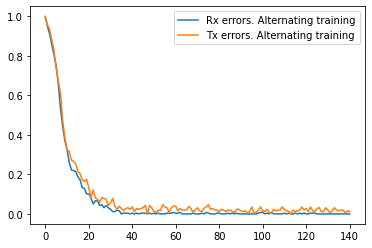

Finished epoch: 149. Error rx: 0.003906. Error tx: 0.015625. Loss rx: 0.031029. Loss tx: -132.893417
Finished training. Error rx: 0.003906. Error tx: 0.015625. Loss rx: 0.031029. Loss tx: -132.893417
Models saved in trained_models/AWGN_256_4_tx.pth, trained_models/AWGN_256_4_rx.pth


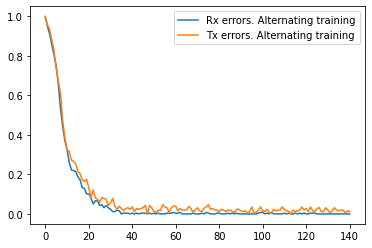

In [20]:
chann_type = "AWGN"
m = 256
n = 4

if train:
    tx, rx, _, _ = train_loop(m=m, n=n, snr_db=10, chann_type=chann_type, n_epochs=150, plot=10)

    tx_filename = "%s/%s_%d_%d_tx.pth" % (MODELS_FOLDER, chann_type, m, n)
    rx_filename = "%s/%s_%d_%d_rx.pth" % (MODELS_FOLDER, chann_type, m, n)
    torch.save(tx.state_dict(), tx_filename)
    torch.save(rx.state_dict(), rx_filename)

    print("Models saved in %s, %s" % (tx_filename, rx_filename))
    
    torch.cuda.empty_cache()

Now we can watch the constellation generated by our Tx. This is done by getting the encoding for all possible messages and then adding 20 noise samples. So for every $m$ message of $M$ we will plot 20 different samples with noise. After adding the noise we will visualize the constellation using 2 dimensional t-SNE. If the encoder is trained properly we would be able to clearly distinguish between the groups of noisy samples of each $m$ message.

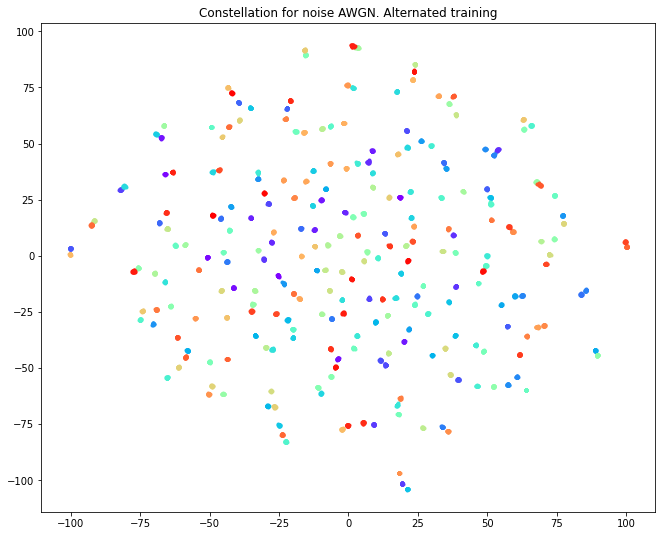

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(11, 9), facecolor='w')
ax = plot_constellation(m=256, n=4, model="alternated", ax=ax, device=device)

Now we can simulate end-to-end communication. We use the pre-trained models to encode a block of messages. First the messages will go through the Tx, then they will go through the channel that will add noise and at the end we will pass them through the Rx. As mentioned before, the Rx will output the probability the received sample corresponds to each $m$ message. We are going to pick the one with highest probability. After this decission we are going to check how many mistakes we had i.e. calculate the Block Error Rate (BLER).

In [21]:
def nn_communication(m, n, snr_db, n_blocks, chann_type="AWGN", model="supervised", verbose=False):
    enc, dec = recover_models(device, model=model, m=m, n=n, chann_type=chann_type)
    
    # Print the parameters of our trained models
    if verbose: print("Models")
    if verbose: print(enc)
    if verbose: print(dec)
    if verbose: print()

    k = math.log2(m)
    # We are not training hence not using gradients. Just evaluating
    with torch.no_grad():
        # Generate as much data as specified in the parameters
        data = torch.randint(0, m, (n_blocks, 1)).to(device)
        if verbose: print("Original x")
        if verbose: print(data)
        
        # Encode the data (Tx)
        enc_data = enc(data)
        if verbose: print("Encoded x")
        if verbose: print(enc_data)
    
        # Pass the data through the channel. Add noise
        noise_data = channel(enc_data, n, k, snr_db, chann_type=chann_type)
        if verbose: print("x with noise")
        if verbose: print(noise_data)
        
        # Decode the data (Rx)
        dec_data = dec(noise_data, chann_type=chann_type)
        
        # The last layer returns probabilites over all possible messages
        # Choos the one that has the highest one
        data_dec = torch.argmax(dec_data, dim=1).unsqueeze(1)
        if verbose: print("Recovered x")
        if verbose: print(data_dec)
        
        # Count the errors that we had
        errors = data_dec != data
        total_errors = errors.sum().to("cpu").numpy()

    # Get the error. Rate of the errrors
    bler = total_errors/n_blocks
    if verbose: print("BLER")
    if verbose: print(bler)

    print("Finished calculations for channel (%s). SNR dB: %f." % (chann_type, snr_db))
    return bler

In [22]:
# Visualize for the alternated approach
nn_communication(m=256, n=4, snr_db=0, n_blocks=10, model="alternated", chann_type="AWGN", verbose=True)
torch.cuda.empty_cache()

Models
Transmitter(
  (transmit): Sequential(
    (0): Embedding(256, 256)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=8, bias=True)
  )
  (normalization): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Receiver(
  (receive): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LogSoftmax()
  )
  (estimate_h): Sequential(
    (0): Linear(in_features=8, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=2, bias=True)
  )
)

Original x
tensor([[124],
        [ 54],
        [187],
        [181],
        [ 94],
        [248],
        [144],
        [241],
        [243],
        [212]], device='cuda:0')
Encoded x
tensor([[[-1.0603, -0.7804],
         [-3.1550,  0.3742],
         [ 1.1954, -3.9883],
         [ 1.3123,  1.3881]],

        [[-2.8534, -0.3190],
         [-2.7750, -0.8482],
         [-1

## Results

We trained our Tx and Rx and a constant noise level of $\text{SNR}_{\text{dB}}= 10$. We are going to plot the BLER we obtain from the system with a range of noise levels from -4 to 12

In [17]:
# Defining all noise levels
snrs_db = np.arange(-4, 12, 1)

# Number of input messages to simulate
n_blocks = 300000

# To store the resutls
results_y = np.zeros(len(snrs_db))

# Iterate over all the (n, k) encodings
for snr_n, snr_db in enumerate(snrs_db):
    # Get the bler using autoencoder
    bler_alternated = nn_communication(m=256, n=4, snr_db=snr_db, n_blocks=n_blocks, chann_type="AWGN")
    
    # Store the results
    results_y[snr_n] = bler_alternated
    
    torch.cuda.empty_cache()

Finished calculations for channel (AWGN). SNR dB: -4.000000.
Finished calculations for channel (AWGN). SNR dB: -3.000000.
Finished calculations for channel (AWGN). SNR dB: -2.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for channel (AWGN). SNR dB: 1.000000.
Finished calculations for channel (AWGN). SNR dB: 2.000000.
Finished calculations for channel (AWGN). SNR dB: 3.000000.
Finished calculations for channel (AWGN). SNR dB: 4.000000.
Finished calculations for channel (AWGN). SNR dB: 5.000000.
Finished calculations for channel (AWGN). SNR dB: 6.000000.
Finished calculations for channel (AWGN). SNR dB: 7.000000.
Finished calculations for channel (AWGN). SNR dB: 8.000000.
Finished calculations for channel (AWGN). SNR dB: 9.000000.
Finished calculations for channel (AWGN). SNR dB: 10.000000.
Finished calculations for channel (AWGN). SNR dB: 11.000000.


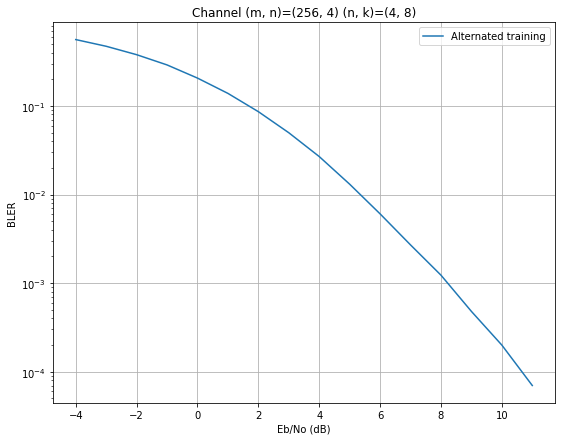

In [18]:
plt.figure(figsize=(9, 7))
plt.semilogy(snrs_db, results_y, label="Alternated training")
plt.legend(loc='upper right')
plt.grid(True)
plt.title("Channel (m, n)=(256, 4) (n, k)=(4, 8)")
plt.xlabel('Eb/No (dB)')
plt.ylabel('BLER')
plt.show()